In [31]:
from importlib import reload
import bayes
reload(bayes)
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing  import scale
from sklearn.model_selection import KFold, ShuffleSplit
from utils import *
np.set_printoptions(precision=2)

In [2]:
def bmi(h, w):
    h = h*0.0254
    w = w * 0.453592
    return w / (h**2)

In [3]:
data = pd.read_csv("diabes.csv")
cols = ["chol", "glyhb", "stab.glu", "hdl", "age", "gender", "obe", "ow" , "bps", "bpd", "whr", "ppt", "> 55" ] # "bmi"
data["whr"] = data["waist"] / data["hip"]
data["bmi"] = bmi(data["height"], data["weight"])
data["ppt"] = data["time.ppn"] < 120
data["obe"] = data["bmi"] > 30
data["ow"] = (data["bmi"] < 30) & (data["bmi"] > 25)
data["> 55"] = data["age"] > 55
data["bps"] = data["bp.1s"] #(data["bp.1s"] + data["bp.2s"])/2
data["bpd"] = data["bp.1d"] #(data["bp.1d"] + data["bp.2d"])/2
df = data[cols]; cols.remove("glyhb")
df = df[~pd.isna(df).any(axis = 1)]
df["gender"] = df["gender"] == "female"
#df["one"] = 1
y_0 = df.pop("glyhb").to_numpy().astype(float)
X = df.to_numpy().astype(float)
y = scale(y_0, with_std=False)
X = scale(X, with_mean=False)



In [4]:
#y = np.log(y_+1)

In [ ]:
model = bayes.Wayfay(nIter=1000, ld0=1, eps=5/10000)
model.fit(y, X)

In [ ]:
beta = model.variables["B"].storage.mean(axis = 0) 
gams = model.gammas.storage.mean(axis=0) 

In [ ]:
sns.set_style("dark")
plt.figure(figsize=(8, 4))
ax = plt.gca()
ax.scatter(y = gams, x = cols, c = gams,  cmap="rainbow") # cmap="cool"
ax.set_ylabel('Proportions')
ax.set_xlabel('Variables indices')
plt.show() 

In [ ]:
BM = pd.DataFrame(model.variables["B"].storage[:, gams > 0.5], columns=np.array(cols)[gams > 0.5])
ZM = pd.DataFrame(model.variables["B"].storage[:, gams < 0.5], columns=np.array(cols)[gams < 0.5])
#sns.violinplot(data=BM,palette="Set1", bw=1,  linewidth=1/4) 
sns.violinplot(data=ZM, palette="Set2", bw=1,  linewidth=1/4)

In [ ]:
model.variables["sig"].storage.mean() , np.median(model.variables["sig"].storage), model.variables["sig"].storage[0]

In [ ]:
sns.set_style("dark")
plt.figure(figsize=(8, 4))
ax = plt.gca()
#ax.scatter(y = model.variables["sig"].storage, x = np.arange(1000),   cmap="rainbow") # cmap="cool"
ax.hist(model.variables["sig"].storage, bins=50)
ax.set_ylabel('Sigma Squared')
ax.set_xlabel('Iteration indices')
plt.show() 

In [ ]:
gams = model.gammas.storage.mean(axis=0) 
#df.columns, gams, gams >  0.5
pd.DataFrame(gams.reshape(1, -1), columns=df.columns)

In [5]:
def ciw(low, y, high):
    return ((low <= y) & (y <= high)).mean()
def liner_0(c, x):
    return x + c*abs(x)
def cisearch(low, high, y, lr = 0.1, thres = 0.95, n = 100):
    curr = ciw(low, y, high)
    a = 1; b = 1
    while curr < thres and n > 1:
        curr_a = ciw(liner(-(a+lr), low), y, liner(b, high))
        curr_b = ciw(liner(-a, low), y, liner((b+lr), high))
        diff_a = curr_a - curr
        diff_b = curr_b - curr
        #print(diff_a, curr, diff_b)
        if diff_a < diff_b:
            b += lr
        elif diff_a == diff_b:
            b += lr
            a += lr
        else:
            a += lr
        curr = ciw(liner(-a, low), y, liner(b, high))
        n -= 1
        #print(a,b)
    print("found", curr)
    return a, b 
def liner(c, x):
    return x + c*abs(x)**(0.33)


In [37]:
np.random.seed(0)
shuffle_split = ShuffleSplit(n_splits=10)
scores = []; cils = []; cov = []; alpha = 0.05/2
ls = np.array([]); hs = ls; preds = ls; ys = ls
for i, (train_indexes, test_indexes) in enumerate(shuffle_split.split(X)):
    print("Fold: ", i)
    model = bayes.Wayfay(nIter=100, ld0=1, eps=5/10000) # 5/10000, 10/10000
    model.fit(y[train_indexes], X[train_indexes]) 
    BM = model.variables["B"].storage
    gam = model.gammas.storage.mean(axis=0) 
    B = BM.mean(axis=0)
    X_ = X[test_indexes] ; y_ = y[test_indexes]
    pred = dot(X_, B)
    l, h = np.quantile(dot(X[train_indexes], BM.T), q = [alpha, 1-alpha], axis =1)
    a, b = cisearch(l, h, y[train_indexes], lr = 0.01, thres = 0.98, n = 500) 
    l, h = np.quantile(dot(X_, BM.T), q = [alpha, 1-alpha], axis =1)
    h = liner(b, h)
    l = liner(-a, l)
    l[l < min(y[train_indexes])] = min(y[train_indexes])
    precision = ciw(l, y_, h)
    diff = y_ - pred
    ls = np.concatenate([ls, l]); hs = np.concatenate([hs, h]); 
    preds = np.concatenate([preds, pred]); ys = np.concatenate([ys, y_]); 
    mse = norm(diff)
    scores.append(mse)
    cils.append(np.mean(h - l))
    cov.append(precision)
    print(mse, precision)

Fold:  0
found 0.9825072886297376
1.7003619551444153 1.0
Fold:  1
found 0.9825072886297376
1.3770849413026545 1.0
Fold:  2
found 0.9825072886297376
1.7097917685879815 0.9487179487179487
Fold:  3
found 0.9825072886297376
1.9317826990130385 0.9743589743589743
Fold:  4
found 0.9825072886297376
3.066876031253452 0.9743589743589743
Fold:  5
found 0.9825072886297376
5.318028979237912 0.9230769230769231
Fold:  6
found 0.9825072886297376
2.501775932708809 0.9743589743589743
Fold:  7
found 0.9825072886297376
3.606120989836662 0.9487179487179487
Fold:  8
found 0.9825072886297376
1.895978413582328 0.9230769230769231
Fold:  9
found 0.9825072886297376
1.8905836691139393 1.0


In [38]:
np.mean(scores), np.mean(cov), np.mean(cils)

(2.4998385379781194, 0.9666666666666666, 6.220581558945679)

In [36]:
scores

[1.668888535345663,
 1.9838318859334028,
 1.4229773442447082,
 2.540285609765577,
 1.1071387232549301,
 4.33571364646282,
 1.4483660156567681,
 3.597948262401204,
 1.5566265609834933,
 3.2787628834339038]

In [172]:
fr = pd.DataFrame({"MSE":scores, "COV":cov, "CIW":cils}, index=["Fold " + str(d+1) for d in np.arange(10)])

In [179]:
frw = round(fr, 4)

In [178]:
to_latex(fr.reset_index())

Fold 1 & 1.7157 & 0.9744 & 6.069 \\ 
Fold 2 & 1.2611 & 1.0 & 5.3084 \\ 
Fold 3 & 0.8781 & 1.0 & 6.0133 \\ 
Fold 4 & 1.2824 & 1.0 & 5.6669 \\ 
Fold 5 & 3.8303 & 0.9744 & 6.0293 \\ 
Fold 6 & 1.4116 & 0.9744 & 6.0392 \\ 
Fold 7 & 1.8173 & 0.9487 & 5.3442 \\ 
Fold 8 & 1.882 & 0.9744 & 5.6052 \\ 
Fold 9 & 1.6701 & 0.9744 & 5.3951 \\ 
Fold 10 & 1.2555 & 1.0 & 5.8861


In [10]:
np.mean([1.25, 1.24, 1.55, 1.21, 1.45, 1.47, 3.44, 1.23])

1.605

<AxesSubplot:>

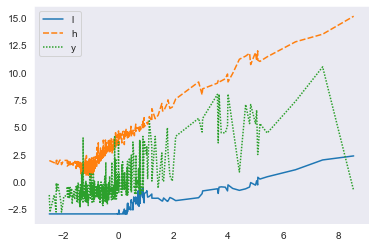

In [139]:
xx = pd.DataFrame({"l":ls, "h":hs, "y":ys}, index=preds)
#sns.scatt(data=xx.T, palette="Set2", bw=1,  linewidth=1/4)
#sns.scatterplot(data=xx)
sns.lineplot(data=xx)

In [104]:
ls.shape

(390,)

In [140]:
cisearch(l, h, y_, thres=0.98)

found 1.0


(1, 1)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
plot_pacf(model.variables["sig"].storage, lags = 50)
plt.show()

In [ ]:
preds = dot(X, B)
errs = y - preds
#sns.set_style("dark")
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.scatter(y = errs, x = y_, c = preds,  cmap="Greys") # cmap="cool"
ax.set_ylabel('trues - predictions')
ax.set_xlabel('True values')
plt.show() 

In [ ]:
df["Residuals"] = errs
sns.displot(df, x = "Residuals")

In [ ]:
df["Estimated values"] = preds + y_.mean()
sns.displot(df, x = "Estimated values")

In [ ]:
#sns.pairplot(data[["chol", "glyhb", "stab.glu","ppt"]], hue="ppt")
# 'chol', 'stab.glu', 'hdl', 'ratio', 'glyhb', 'location', 'age'
sns.relplot(x="age", y="glyhb", data = data)

In [145]:
from ngboost import NGBRegressor
from sklearn.model_selection import train_test_split
from ngboost.distns import LogNormal
from scipy.stats import lognorm

In [ ]:
#from scipy.stats import norm

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
ngb = NGBRegressor().fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

In [ ]:
x = Y_dists.params["scale"]

In [ ]:
(x*4).mean()

In [198]:
np.random.seed(0)
shuffle_split = ShuffleSplit(n_splits=10)
scores = []; cils = []; cov = []; alpha = 0.005/2
ls = np.array([]); hs = ls; preds = ls; ys = ls
for i, (train_indexes, test_indexes) in enumerate(shuffle_split.split(X)):
    print("Fold: ", i)
    model = NGBRegressor(Dist=LogNormal)
    model.fit(X[train_indexes], y_0[train_indexes]) 
    X_ = X[test_indexes] ; y_ = y_0[test_indexes]
    dists = model.pred_dist(X_).params
    sd = dists["scale"]
    pred, sd = lognorm.stats(dists["s"], scale = sd, moments="mv")#dists["loc"]
    sd = np.sqrt(sd)
    l, h = pred - 6*sd, pred + 6*sd
    precision = ciw(l, y_, h)
    diff = y_ - pred
    #diff = y[test_indexes] - np.exp(dot(X[test_indexes], B))
    ls = np.concatenate([ls, l]); hs = np.concatenate([hs, h]); 
    preds = np.concatenate([preds, pred]); ys = np.concatenate([ys, y_]); 
    mse = norm(diff)
    scores.append(mse)
    cils.append(np.mean(h - l))
    cov.append(precision)
    print(mse, precision)

Fold:  0
[iter 0] loss=1.9473 val_loss=0.0000 scale=1.0000 norm=0.6589
[iter 100] loss=1.2978 val_loss=0.0000 scale=2.0000 norm=0.8747
[iter 200] loss=1.0484 val_loss=0.0000 scale=1.0000 norm=0.4129
[iter 300] loss=0.9249 val_loss=0.0000 scale=1.0000 norm=0.4185
[iter 400] loss=0.8390 val_loss=0.0000 scale=1.0000 norm=0.4209
1.5149380461114876 1.0
Fold:  1
[iter 0] loss=1.9348 val_loss=0.0000 scale=1.0000 norm=0.6712
[iter 100] loss=1.2707 val_loss=0.0000 scale=1.0000 norm=0.4260
[iter 200] loss=1.0541 val_loss=0.0000 scale=1.0000 norm=0.4038
[iter 300] loss=0.9365 val_loss=0.0000 scale=1.0000 norm=0.4101
[iter 400] loss=0.8480 val_loss=0.0000 scale=1.0000 norm=0.4133
1.943382733849237 1.0
Fold:  2
[iter 0] loss=1.8896 val_loss=0.0000 scale=1.0000 norm=0.6620
[iter 100] loss=1.2202 val_loss=0.0000 scale=1.0000 norm=0.4181
[iter 200] loss=1.0019 val_loss=0.0000 scale=1.0000 norm=0.4052
[iter 300] loss=0.8802 val_loss=0.0000 scale=1.0000 norm=0.4057
[iter 400] loss=0.8044 val_loss=0.0000

In [199]:
np.mean(scores), np.mean(cov), np.mean(cils)

(2.352638267490125, 0.9794871794871796, 7.905137760635102)

In [188]:
frn = pd.DataFrame({"MSE":scores, "COV":cov, "CIW":cils}, index=["Fold " + str(d+1) for d in np.arange(10)])
frn = round(frn, 4)
to_latex(fr.reset_index())


Fold 1 & 1.7157 & 0.9744 & 6.069 & 1.5149 & 0.7179 & 2.5105 \\ 
Fold 2 & 1.2611 & 1.0 & 5.3084 & 1.9434 & 0.7436 & 2.6955 \\ 
Fold 3 & 0.8781 & 1.0 & 6.0133 & 4.5154 & 0.641 & 2.6976 \\ 
Fold 4 & 1.2824 & 1.0 & 5.6669 & 4.3707 & 0.7179 & 2.3703 \\ 
Fold 5 & 3.8303 & 0.9744 & 6.0293 & 1.1396 & 0.8974 & 3.0518 \\ 
Fold 6 & 1.4116 & 0.9744 & 6.0392 & 2.7402 & 0.7436 & 2.5669 \\ 
Fold 7 & 1.8173 & 0.9487 & 5.3442 & 2.6767 & 0.7436 & 2.4802 \\ 
Fold 8 & 1.882 & 0.9744 & 5.6052 & 0.9686 & 0.8974 & 2.6298 \\ 
Fold 9 & 1.6701 & 0.9744 & 5.3951 & 1.095 & 0.8462 & 2.5446 \\ 
Fold 10 & 1.2555 & 1.0 & 5.8861 & 2.5618 & 0.8718 & 2.8032


In [187]:
fr = frw.merge(frn, left_index=True, right_index=True)

<AxesSubplot:>

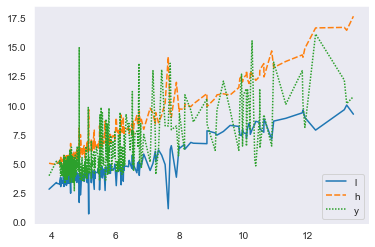

In [166]:
xx = pd.DataFrame({"l":ls, "h":hs, "y":ys}, index=preds)
#sns.scatt(data=xx.T, palette="Set2", bw=1,  linewidth=1/4)
#sns.scatterplot(data=xx)
sns.lineplot(data=xx)

In [192]:
fr.mean()

MSE_x    1.70041
COV_x    0.98207
CIW_x    5.73567
MSE_y    2.35263
COV_y    0.78204
CIW_y    2.63504
dtype: float64

In [194]:
y_0.shape

(382,)